In [1]:
"""
Import modules
"""

import TBEST as tb
from fun_variance import nZ_covariance
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
'''
Dictate the figure structure
'''

#sns.set_theme()
font = {'family': 'Times New Roman', 'size': 22}
matplotlib.rc('font', **font)

In [3]:
'''
Load Control Matrix for reconstruction of pseudo-open modes
'''

G = pd.read_csv('G.csv', header=None)  # Gradient matrix
G = np.asarray(G)
Gc = G[1:16, :]  # first row is index

In [4]:
hRadOrd = 4  # higher radial order in the fit
lRadOrd = 2  # lower radial order in the fit
mRO = 0  # nbr of last radial orders excluded from the fit
modes_excluded = np.array([])  # Noll modes to exclud from the fit (focus)

# modes to fit

fRadOrds = np.arange(lRadOrd, hRadOrd + 1 - mRO)
fModes = np.array([], dtype=int)
for iRadOrd in range(fRadOrds.size):
    fModes = np.append(fModes, tb.modesOfRadialOrder(fRadOrds[iRadOrd]))

print('Modes included in the fit: ',fModes)

Modes included in the fit:  [ 4  5  6  7  8  9 10 11 12 13 14 15]


In [5]:
J = tb.nModesFromRadialOrder(hRadOrd) # What is the Maximum mode ?

# Diameter of the ATs in the VLTI
D = 1.8

# Size of the matrix for the calculation of the cross-talk matrix
M = 30

# Fitted gradient columns
Gf = G.T[:, 1:J + 1]

# Pseudo inverse reconstructor
inv_Gf = np.linalg.pinv(Gf)
# Remaining gradient columns
Gr = G.T[:, J + 1:M + 2]

# cross-coupling matrix (As defined by Dai1996)
c = np.matmul(inv_Gf, Gr)

In [10]:
# slopes data
slopes_data = pd.read_csv('slopes_oopao.csv')
slopes_data = np.asarray(slopes_data)

# noise contribution - noise magnitude obtained from on-sky samples (N=50)
noise_cont = 1e-7
# measurement error contribution added to the slopes
err = np.random.normal(0, noise_cont, slopes_data.shape)
noise_slopes = slopes_data + err

# Value of the r0 (Fried parameter) used for the generation of the slopes
true_r0 = 0.136991 # [meters]

# Estimation at 20 seconds, with 500 Hz loop rate
time = int(20*500)

zernike_c_noise_f = np.matmul(noise_slopes, np.linalg.pinv(Gc))[:time].T
# removing piston, tip/tilt
zernike_c_noise = zernike_c_noise_f[3:]

bi2_noise = np.var(zernike_c_noise, axis=1)
fusco_noise = tb.noiseVariance(zernike_c_noise)
recup_bi2 = bi2_noise - fusco_noise


"""
Fit the Zernike variances and compare results
"""

inv_Gf = np.linalg.pinv(Gc)

#creating an appropriate vector for the function (padding piston, tip/tilt as 0s, since they are not included in the real telemetry)
bi2_noise_extended = np.zeros(15)
bi2_noise_extended[3:] = bi2_noise

fusco_noise_extended = np.zeros(15)
fusco_noise_extended[3:] = fusco_noise

# Finally we fit the reconstructed values with our algorithm

tp_0 = tb.Turbulence_Estimator(D, fModes, bi2_noise_extended, si2_nn= fusco_noise_extended, modes_excluded=modes_excluded)

# Estimated parameters
r0 = tp_0.tp[0]
L0 = tp_0.tp[1]

initial_estimation_r0 = r0

# Calculation of the remaining error contributions
aiaj_0 = nZ_covariance(r0, L0, D, M)
si2_cc_1 = tb.ccCorrection(J, M + 15, c, aiaj_0)

# Estimate with cross-talk estimation
tp_1 = tb.Turbulence_Estimator(D, fModes, bi2_noise_extended, si2_nn= fusco_noise_extended, si2_cc=si2_cc_1,modes_excluded=modes_excluded)

tp_2 = tp_1

# Iterate algorithm
for vv in range(4):

    r0 = tp_2.tp[0]
    L0 = tp_2.tp[1]
    aiaj_2 = nZ_covariance(r0, L0, D, M)
    si2_cc_2 = tb.ccCorrection(J, M + 15, c, aiaj_2)

    tp_2 = tb.Turbulence_Estimator(D, fModes, bi2_noise_extended, si2_nn= fusco_noise_extended, si2_cc=si2_cc_2, modes_excluded=modes_excluded)


final_estimation_r0 = tp_2.tp[0]

print(r'True r0 =',true_r0*100,' [cm]')
print(r'0th iteration r0 =', initial_estimation_r0*100,' [cm]')
print(r'5th iteration r0 =', final_estimation_r0*100,' [cm]')

print('Convergence bias to real r0 =', (final_estimation_r0 - true_r0)/true_r0*100,'%')

True r0 = 13.6991  [cm]
0th iteration r0 = 14.521868285744285  [cm]
5th iteration r0 = 13.827094493743664  [cm]
Convergence bias to real r0 = 0.9343277568866812 %


Text(0, 0.5, 'Modal variance [rad]')

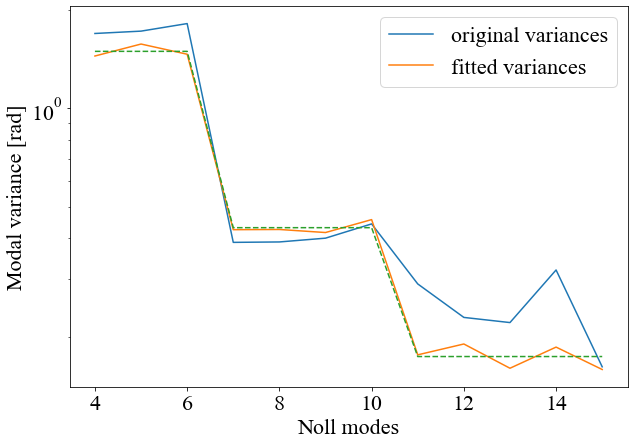

In [24]:
plt.figure(figsize=(10,7))
plt.plot(fModes,bi2_noise, label = 'original variances')
plt.plot(fModes,tp_2.fitted_ai2, label = 'fitted variances')
plt.plot(fModes,tb.nZ_variance(tp_2.tp[0],tp_2.tp[1],D,J)[3:],'--')
plt.legend()
plt.yscale('log')
plt.xlabel('Noll modes')
plt.ylabel('Modal variance [rad]')